In [2]:
# Customized from https://www.tensorflow.org/tutorials/audio/simple_audio#next_steps
import tensorflow as tf
import os
import pathlib
print("tensorflow version", tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
#import torch
#import torchaudio


from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

#Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


tensorflow version 2.15.0


In [50]:
def stereo_to_mono_convertor(signal):
    # If there is more than 1 channel in your audio
    if signal.shape[0] > 1:
        # Do a mean of all channels and keep it in one channel
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

In [61]:
# Dataset_path finds data in folder
DATASET_PATH = 'data/mini_speech_commands'

# Downloads data from Google folder 
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data'
  )

# Folder has been created, delete the .asd files
import os
from pydub import AudioSegment
for folder in os.listdir(data_dir):
  if folder == 'README.md':
    continue
  for file in os.listdir(os.path.join(data_dir,folder)):
    file_path = os.path.join(data_dir,folder,file)
    # If it's a text file, delete it
    if file.endswith('.wav.asd'):
      os.remove(file_path)
    if folder == 'close':
      if file.endswith('.wav'):
        stereo_audio = AudioSegment.from_file(file_path, format="wav")
        mono_audios = stereo_audio.split_to_mono() 
        if len(mono_audios) > 1:
          print(os.path.join(file_path))
          # mono = mono_audios[0].export(os.path.join(data_dir,folder, file), format="wav")



  
      

In [63]:
# Finds command folder labels
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['close' 'down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [64]:
# Prints data about files, splits some for training and some for testing accuracy
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8038 files belonging to 9 classes.
Using 6431 files for training.
Using 1607 files for validation.

label names: ['close' 'down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [65]:
# Prints data about training
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [66]:
# Here is where we would add data pre-processing in training code
# Squeeze edits code samples
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
#  if audio.shape[0] > 1:
        # Do a mean of all channels and keep it in one channel
  #audio = torch.mean(audio, dim=0, keepdim=True)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [67]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [68]:
# Sets an audio sample, prints shape of sample and its label
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [69]:
label_names[[1,1,3,0]]

array(['down', 'down', 'left', 'close'], dtype='<U5')

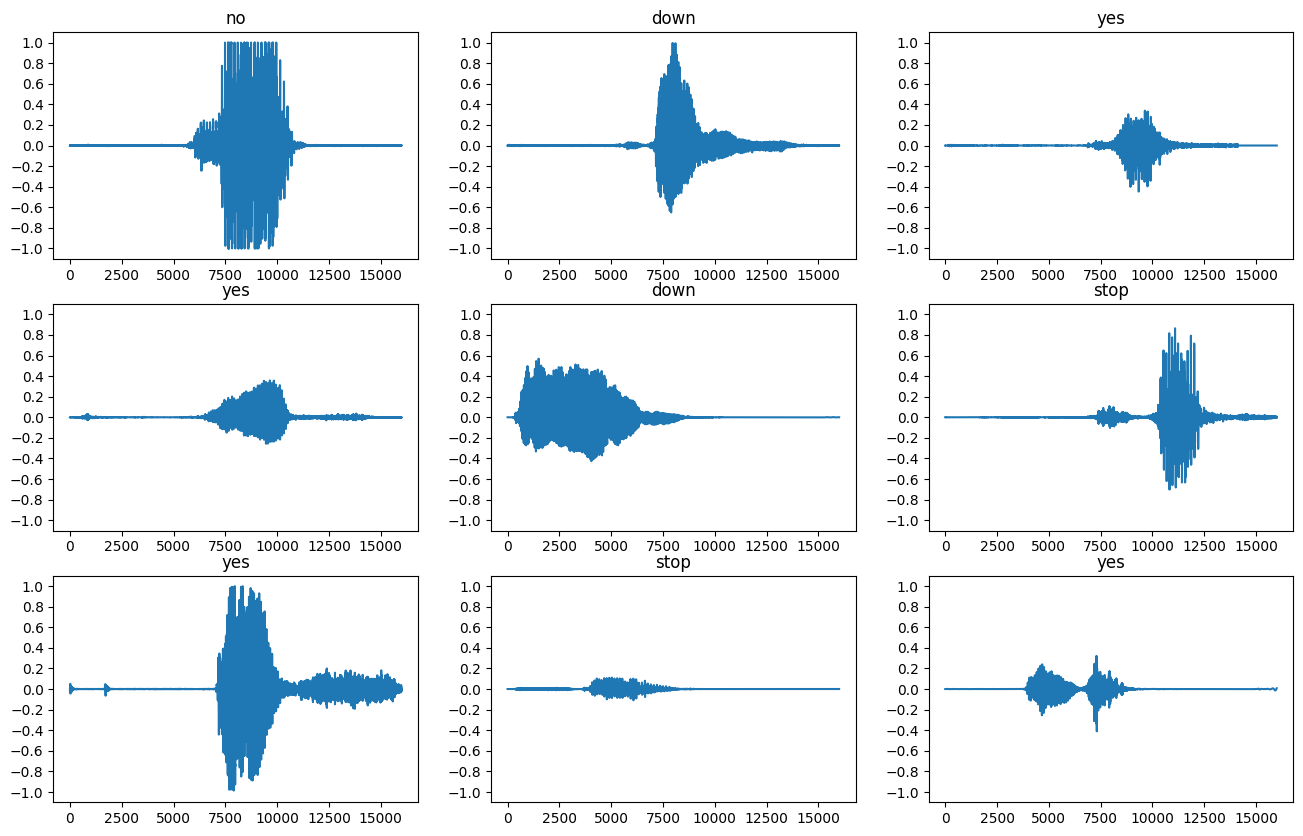

In [70]:
# Prints waveforms for audio examples
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [71]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [72]:
#Prints information about example with audioclip
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [73]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

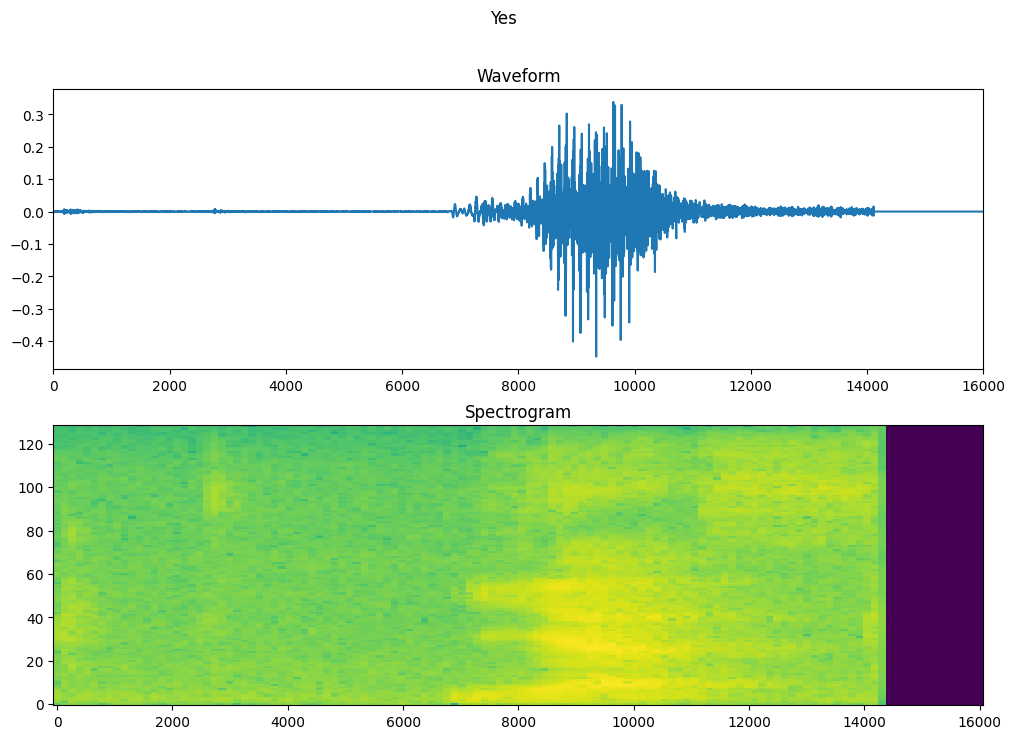

In [74]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [75]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [76]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [77]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

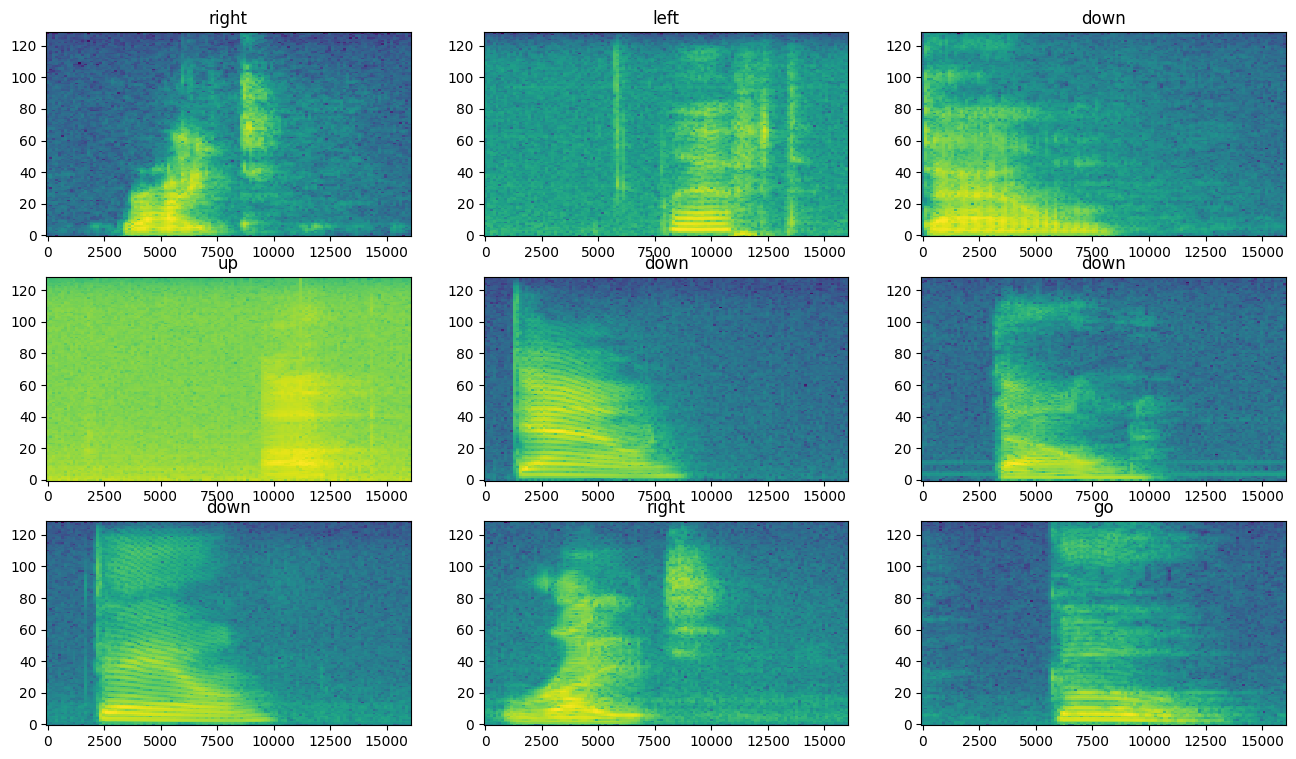

In [78]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [79]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [80]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_3 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)          

In [81]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [82]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


101/101 [==============================] - 9s 69ms/step - loss: 1.8493 - accuracy: 0.3278 - val_loss: 1.4261 - val_accuracy: 0.5265
Epoch 2/20
101/101 [==============================] - 6s 58ms/step - loss: 1.3099 - accuracy: 0.5410 - val_loss: 1.0479 - val_accuracy: 0.6697
Epoch 3/20
101/101 [==============================] - 6s 62ms/step - loss: 1.0096 - accuracy: 0.6442 - val_loss: 0.8526 - val_accuracy: 0.6955
Epoch 4/20
101/101 [==============================] - 6s 59ms/step - loss: 0.8592 - accuracy: 0.6932 - val_loss: 0.7411 - val_accuracy: 0.7639
Epoch 5/20
101/101 [==============================] - 6s 61ms/step - loss: 0.7118 - accuracy: 0.7465 - val_loss: 0.6562 - val_accuracy: 0.7935
Epoch 6/20
101/101 [==============================] - 6s 60ms/step - loss: 0.6282 - accuracy: 0.7783 - val_loss: 0.5692 - val_accuracy: 0.8168
Epoch 7/20
101/101 [==============================] - 6s 62ms/step - loss: 0.5646 - accuracy: 0.8014 - val_loss: 0.5576 - val_accuracy: 0.82

In [83]:
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets
